In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/curlew-sound-3.wav
/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/cricket-sounds-for-sleep-48.wav
/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/sparrow-sound-effect-39.wav
/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/crow-cawing-sound-effect-9.wav
/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/cricket-sounds-for-sleep-5.wav
/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/rain-thunder-and-crickets-sound-effect-4.wav
/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/crickets-chirping-crickets-sound-0.wav
/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/cricket-sounds-for-sleep-29.wav
/kaggle/input/z

## 1. Load dependencies

In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio

## 2. Build Data Loading Functions

### 2.1. Define Paths to Files

In [3]:
capuchin_file = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips/XC114131-0.wav'
not_capuchin_file = '/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips/Crickets-chirping-0.wav'

### 2.2. Building Dataloading Function

In [4]:
import librosa
import tensorflow as tf

def load_wav_16k_mono(filename):
    # Load file with librosa instead of TensorFlow I/O
    wav, sr = librosa.load(filename, sr=16000, mono=True)
    return tf.convert_to_tensor(wav, dtype=tf.float32)

wave = load_wav_16k_mono(capuchin_file)


# def load_wav_16k_mono(filename):
#     # Load encoded wav file
#     file_contents = tf.io.read_file(filename)
#     # Decode wav (tensors by channels) 
#     wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
#     # Removes trailing axis
#     wav = tf.squeeze(wav, axis=-1)
#     sample_rate = tf.cast(sample_rate, dtype=tf.int64)
#     # Goes from 44100Hz to 16000hz - amplitude of the audio signal
#     wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
#     return wav

### 2.3. Plot Wave

In [5]:
wave = load_wav_16k_mono(capuchin_file)
nwave = load_wav_16k_mono(not_capuchin_file)

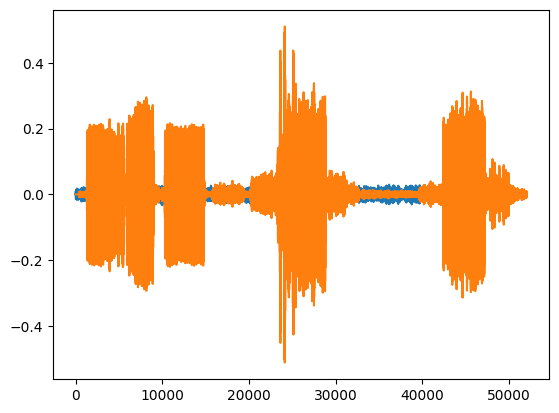

In [6]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

## 3. Create Tensorflow Dataset

### 3.1 Define Paths to Positive and Negative Data

In [7]:
POS = "/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips" 
NEG = "/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Not_Capuchinbird_Clips"

### 3.2 Create Tensorflow Datasets

In [8]:
pos = tf.data.Dataset.list_files(POS+'/*.wav')
neg = tf.data.Dataset.list_files(NEG+'/*.wav')

### 3.3 Add labels and Combine Positive and Negative Samples

In [9]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

## 4. Determine Average Length of a Capuchin Call

### 4.1 Calculate Wave Cycle Length

In [10]:
lengths = []
for file in os.listdir('/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips'):
    tensor_wave = load_wav_16k_mono(os.path.join('/kaggle/input/z-by-hp-unlocked-challenge-3-signal-processing/Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

### 4.2 Calculate Mean, Min and Max

In [11]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=54156>

In [12]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [13]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=80000>

## 5. Build Preprocessing Function to Convert to Spectrogram

### 5.1 Build Preprocessing Function

In [14]:
def preprocess(file_path, label):
    def load_and_preprocess(file_path):
        file_path = file_path.numpy().decode("utf-8")  # Convert tensor to string
        wav = load_wav_16k_mono(file_path)  # Load audio file (ensure this function is defined)
        wav = wav[:48000]
        zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
        wav = tf.concat([zero_padding, wav], 0)
        spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
        spectrogram = tf.abs(spectrogram)
        spectrogram = tf.expand_dims(spectrogram, axis=2)
        return spectrogram

    spectrogram = tf.py_function(load_and_preprocess, [file_path], tf.float32)
    spectrogram.set_shape((1491, 257, 1))  # Set shape manually
    return spectrogram, label

### 5.2 Test Out the Function and Viz the Spectrogram

In [15]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [16]:
spectrogram, label = preprocess(filepath, label)

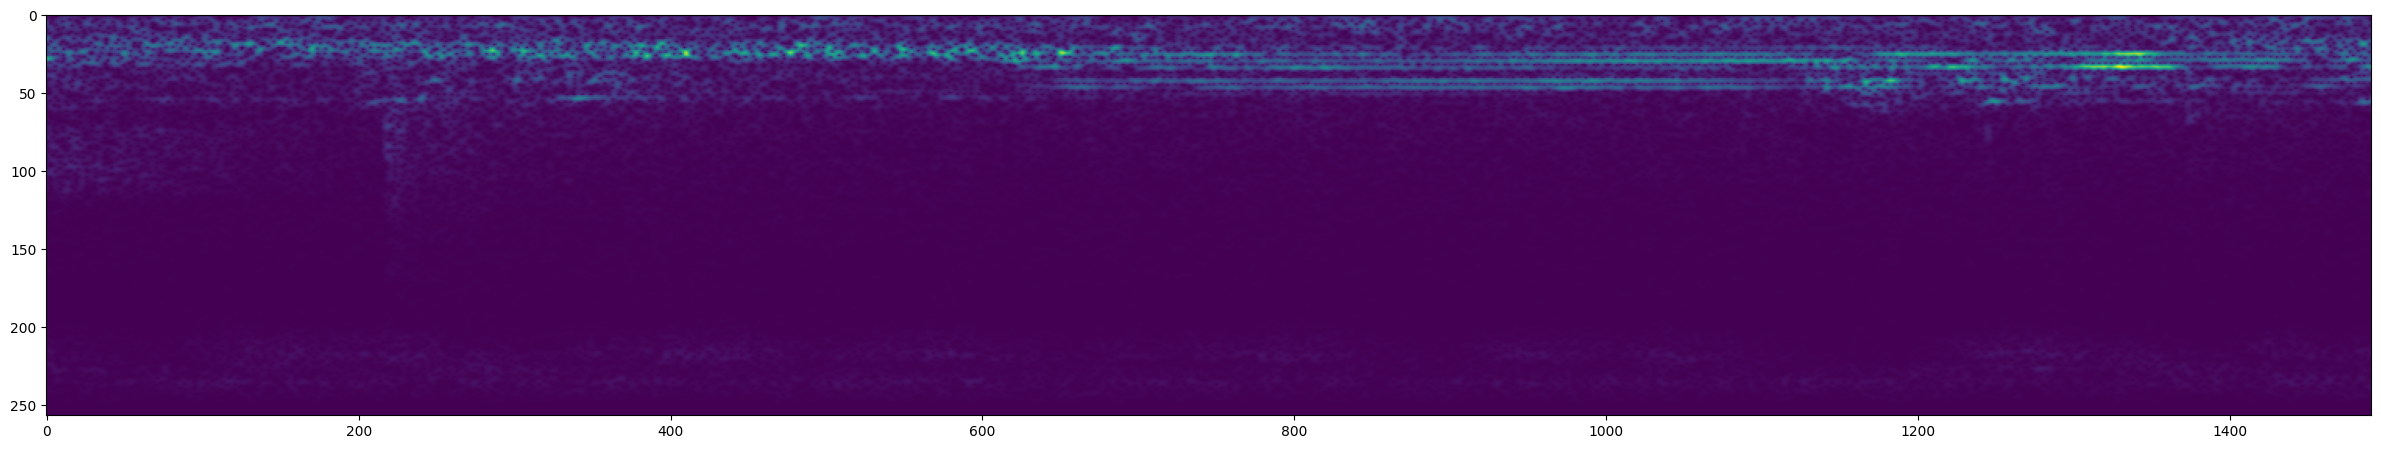

In [17]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

## 6. Create Training and Testing Partitions

### 6.1 Create a Tensorflow Data Pipeline

In [18]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

### 6.2 Split into Training and Testing Partitions

In [19]:
train = data.take(36)
test = data.skip(36).take(15)

### 6.3 Test One Batch

In [20]:
samples, labels = train.as_numpy_iterator().next()

In [21]:
samples.shape

(16, 1491, 257, 1)

## 7. Build Deep Learning Model

### 7.1 Load Tensorflow Dependencies


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

### 7.2 Build Sequential Model, Compile and View Summary

In [23]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense

# Define the input shape (match it to your spectrogram shape)
input_shape = (1491, 257, 1)  # (Time, Frequency, Channels)

model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=input_shape))  # Define input shape here
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='Adam', 
              loss='BinaryCrossentropy', 
              metrics=[tf.keras.metrics.Recall(), tf.keras.metrics.Precision()])

# Print model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 1489, 255, 16)       │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 1487, 253, 16)       │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6019376)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │     770,480,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 770,482,865 (2.87 GB)

 Trainable params: 770,482,865 (2.87 GB)

 Non-trainable params: 0 (0.00 B)

### 7.3 Fit Model, View Loss and KPI Plots

In [24]:
for spectrogram, label in train.take(1):
    print("Spectrogram shape:", spectrogram.shape)
    print("Label shape:", label.shape)


Spectrogram shape: (16, 1491, 257, 1)
Label shape: (16,)


In [25]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 440s 12s/step - loss: 7.7442 - precision: 0.7305 - recall: 0.8994 - val_loss: 0.4758 - val_precision: 0.8710 - val_recall: 1.0000
Epoch 2/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 449s 12s/step - loss: 0.0399 - precision: 0.9577 - recall: 0.9979 - val_loss: 0.0098 - val_precision: 1.0000 - val_recall: 0.9833
Epoch 3/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 454s 13s/step - loss: 0.0121 - precision: 0.9868 - recall: 1.0000 - val_loss: 3.3347e-04 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/4
36/36 ━━━━━━━━━━━━━━━━━━━━ 419s 12s/step - loss: 5.5267e-04 - precision: 1.0000 - recall: 1.0000 - val_loss: 4.4696e-04 - val_precision: 1.0000 - val_recall: 1.0000


In [30]:
loss, recall, precision = model.evaluate(test)
accuracy = (2 * precision * recall) / (precision + recall)  # F1-score formula
print(f"Accuracy (F1-score approximation): {accuracy:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - loss: 3.7845e-04 - precision: 1.0000 - recall: 1.0000
Accuracy (F1-score approximation): 1.0000


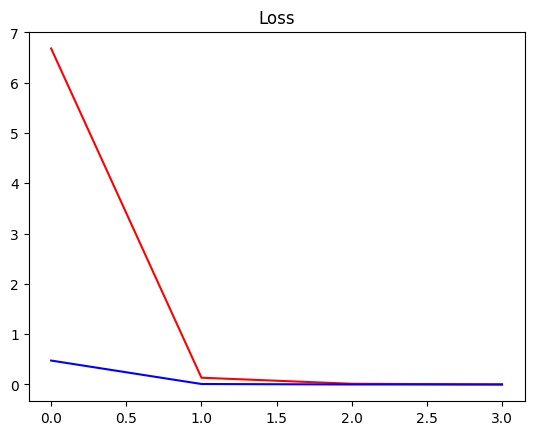

In [31]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

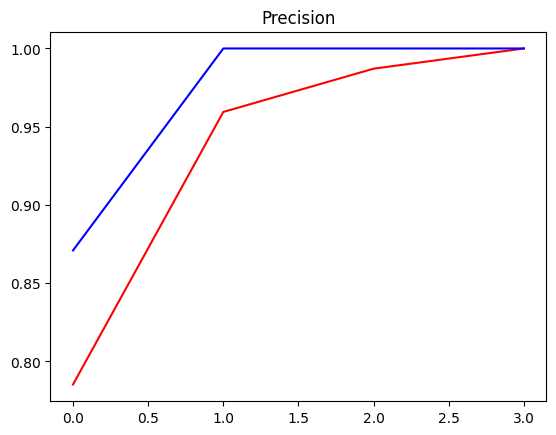

In [32]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

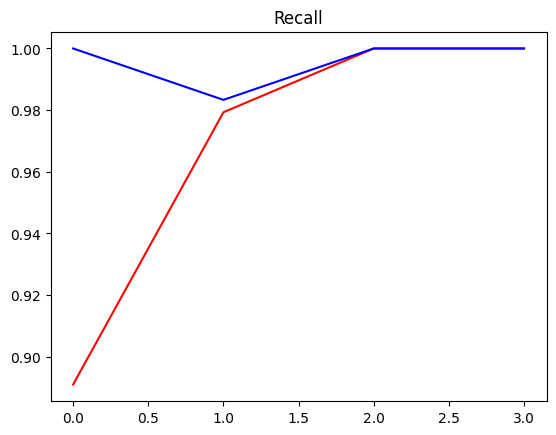

In [33]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()